## Final Modeling, Evaluation and Deployment

This notebook focuses on training, tuning and evaluating advanced Machine Learning Models to predict Revenue Per User (RPU).

Building on latest feature engineerind dataset, ML models such as Random Forest, XGBoost and ensemble techniques are used with cross-validation and hyperparamater optimization.

The goal is to improve predictive performance and generate actionable insights for stakeholder decision-making.

In [3]:
import numpy as np
import pandas as pd

In [5]:
# Load the feature-engineered dataset
df = pd.read_csv("data/enhanced_gaming_trends_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   platform                                       4989 non-null   object 
 1   daily_active_users_dau                         4989 non-null   int64  
 2   new_registrations                              4989 non-null   int64  
 3   session_duration_minutes                       4989 non-null   float64
 4   ingame_purchases_                              4989 non-null   float64
 5   social_media_mentions                          4989 non-null   int64  
 6   stream_viewership                              4989 non-null   float64
 7   revenue_                                       4989 non-null   float64
 8   top_genre                                      4989 non-null   object 
 9   influencer_endorsements                        4989 

In [7]:
# One-hot encode 'top_genre' and 'platform'
df_encoded = pd.get_dummies(df, columns=['top_genre', 'platform'])

# Display the new shape and column names to confirm encoding
df_encoded.shape, df_encoded.columns.tolist()

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 42 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   daily_active_users_dau                         4989 non-null   int64  
 1   new_registrations                              4989 non-null   int64  
 2   session_duration_minutes                       4989 non-null   float64
 3   ingame_purchases_                              4989 non-null   float64
 4   social_media_mentions                          4989 non-null   int64  
 5   stream_viewership                              4989 non-null   float64
 6   revenue_                                       4989 non-null   float64
 7   influencer_endorsements                        4989 non-null   int64  
 8   revenue_per_user                               4989 non-null   float64
 9   log_revenue_per_user                           4989 

#### Random Forest Regression

* Random Forest Regression is applied as a non-linear ensemble model to capture complex relationships between engagement, platform, and monetization features.
* It is robust to feature interactions and outliers, making it well-suited for this dataset.
* Cross-validation is used to evaluate baseline performance and Grid/Randomized Search to fine-tune hyperparameters for optimal accuracy.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
# define feature columns (including interaction features and relevant numerics)
features = [
    'new_registrations',
    'stream_viewership',
    'ingame_purchases_',
    'social_media_mentions',
    'dau_x_duration',
    'stream_viewers_per_player',
    'purchases_per_session',
    'top_genre_Action',
    'top_genre_Adventure',
    'top_genre_FPS',
    'top_genre_RPG',
    'top_genre_Simulation',
    'platform_Mobile',
    'platform_PC',
    'platform_VR',
    'platform_Console'
]

#target
target = 'log_revenue_per_user'

#prepare data
X = df_encoded[features]
y = df_encoded[target]

#split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#initialize RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#k-fold cross validation on training set
r2_scores_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
mse_scores_cv = -cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#fit on full training data
rf_model.fit(X_train, y_train)

#predict on test data
y_pred = rf_model.predict(X_test)

#Evaluate on test data
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

#results
{
    "Cross-Validated R2 Mean (Train)": np.mean(r2_scores_cv),
    "Cross-Validated MSE Mean (Train)": np.mean(mse_scores_cv),
    "Test R2": r2_test,
    "Test MSE": mse_test
}

{'Cross-Validated R2 Mean (Train)': 0.6114317838265138,
 'Cross-Validated MSE Mean (Train)': 0.08237519867775014,
 'Test R2': 0.6128420769746669,
 'Test MSE': 0.07828032587515146}

#### Summary of Random Forest Performance

* Cross-Validated R2 (Train)	~61.1%	-> Good model generalization across folds
* Cross-Validated MSE (Train)	~0.082	-> Low average squared error during training Cross-Validation
* Test R2	~61.% -> Solid prediction on unseen data.
* Test MSE	~0.079 -> Consistently low error on test set.

* The model explains ~61% of the variance in log_revenue_per_user, even after accounting for real-world noise.

* Model doesn't overfit (CV and test R² are close).

* Feature engineering has clearly helped (see improvement over baseline).

In [29]:
from sklearn.model_selection import GridSearchCV

In [31]:
#---------Apply GridSearchCV to RandomForestRegressor------

#define param grid
param_grid = {
    'n_estimators': [100,200,500],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt']
}

#initialize gridserachcv
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

#fit grid search
grid_search.fit(X_train, y_train)

#best estimator evaluation on test
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

#metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

{
    "Best Params": grid_search.best_params_,
    "Test R2": r2,
    "Test MSE": mse
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'Best Params': {'max_depth': 8,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200},
 'Test R2': 0.6282736943347909,
 'Test MSE': 0.07516017266663219}

* GridSearchCV-tuned Random Forest achieved a noticeable improvement over the baseline, boosting R2 on the test set from ~61% to ~63%.

* Fine-tuning paramaters such as max_depth, min_samples_split and n_estimators helped reduce prediction error and capture more variance in revenue per user.

* The demonstrates the effectiveness of hyperparameter optimization in enhancing model performance without overfitting.

In [33]:
#---------------Apply RandomizedSearchCV to RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#define param grid
param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(4, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

#initialize randomizedserachcv
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=30, cv=5, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

#fit randomized serach
random_search_rf.fit(X_train, y_train)

#best estimator evaluation on test
best_rf_rscv = random_search_rf.best_estimator_
y_pred = best_rf_rscv.predict(X_test)

#results
print("Best Params:", best_rf_rscv)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE", mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: RandomForestRegressor(max_depth=12, max_features='log2', min_samples_leaf=8,
                      min_samples_split=17, n_estimators=537, random_state=42)
Test R²: 0.6334596634685314
Test MSE 0.0741116099752234


#### Model Comparison: Random Forest Variants

* Baseline Random Forest -> R2 (Test) : ~61% , MSE (Test) : ~0.078
* GridSearchCV(Best Params) -> R2 (Test) : ~63% , MSE (Test) : ~0.075
* RandomizedSearchCV(Best Params) -> R2 (Test) : ~63.3% , MSE (Test) : ~0.074


* Both GridSearchCV and RandomizedSearchCV significantly outperformed the baseline model.
* RandomizedSearchCV achieved comparable performance to GridSearchCV while searching fewer combinations, making it a faster and resource-efficient alternative.

### Exploring XGBoost

After identifying RandomizedSearchCV-tuned Random Forest as the best-performing model so far, now we can explore XGBoost, a powerful gradient boosting framework known for its performance.

Goal is to evaluate whether XGBoost can outperform the current best model in predicting revenue per user and generalizing across unseen data.

In [36]:
!pip install xgboost

In [30]:
import xgboost as xgb

In [32]:
param_grid = {
    'n_estimators':[300, 500],
    'max_depth':[4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1,2]
}

#initialize and evaluate XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

#best estimator evaluation on test
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

#metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

{
    "Best Params": grid_search.best_params_,
    "Test R2": r2,
    "Test MSE": mse
}
# #k-fold cross validation on training set
# r2_scores_cv_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring = 'r2')
# mse_scores_cv_xgb = -cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# #fit on full training data
# xgb_model.fit(X_train, y_train)

# #predict on test data
# y_pred = xgb_model.predict(X_test)

# #evaluate
# r2_test_xgb = r2_score(y_test, y_pred)
# mse_test_xgb = mean_squared_error(y_test, y_pred)

# #results
# {
#     "Cross-Validated R2 Mean (Train)": np.mean(r2_scores_cv_xgb),
#     "Cross-Validated MSE Mean (Train)": np.mean(mse_scores_cv_xgb),
#     "Test R2": r2_test_xgb,
#     "Test MSE": mse_test_xgb
# }

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'Best Params': {'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 300,
  'reg_alpha': 0.1,
  'reg_lambda': 2,
  'subsample': 0.8},
 'Test R2': 0.61978434358944,
 'Test MSE': 0.07687665347018026}

Since XGBoost did not outperform RandomizedSearchCV-tuned Random Forest, further GridSearch tuning was skipped for XGBoost.

Instead, RandomizedSearchCV was directly applied to fine-tune XGBoost's hyperparameters and compare its performance with our current best model.

In [34]:
#random search cv for XGBoost
from scipy.stats import uniform

param_dist = {
    'n_estimators': randint(300, 800),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 0.2),
    'reg_lambda': uniform(1, 2)
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=30, scoring='r2', cv=5, n_jobs=-1, verbose=1
)

random_search_xgb.fit(X_train, y_train)

#best estimator evaluation on test
best_xgb_rscv = random_search_xgb.best_estimator_
y_pred = best_xgb_rscv.predict(X_test)


print("Best Params:", best_xgb_rscv)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE", mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8563200835612523, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.021815115947153144,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=483, n_jobs=None,
             num_parallel_tree=None, ...)
Test R²: 0.6075772417588468
Test MSE 0.07934483467598621


#### Performance Comaprison:

- Random Forest (RandomizedSearchCV):
  - Test R2 : ~63.34%
  - Test MSE :  ~0.0741
 
- XGBoost (RandomizedSearchCV):
    - Test R2 : ~61%
    - Test MSE : ~0.079

Although XGBoost performed reasonably well, **the RandomizedSearchCV-tuned Random Forest remains the top-performing model on this dataset.**

### Ensemble Techniques

* To leverage the strengths of both Random Forest and XGBoost, VotingRegressor ensemble is applied using their best-tuned models.

* The idea is to combine their predictive power to achieve more stable and generalized performance.

In [157]:
rf_best = random_search_rf.best_estimator_
xgb_best = random_search_xgb.best_estimator_

In [159]:
from sklearn.ensemble import VotingRegressor

#ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('rf', rf_best),
     ('xgb', xgb_best)
])

#cross validation
r2_cv = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='r2')
mse_cv = -cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#fit and evaluate on test set
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

{
    "Cross-Validated R2 Mean (Train)": np.mean(r2_cv),
    "Cross-Validated MSE Mean (Train)": np.mean(mse_cv),
    "Test R2": r2_test,
    "Test MSE": mse_test
}

{'Cross-Validated R2 Mean (Train)': 0.6290904398092585,
 'Cross-Validated MSE Mean (Train)': 0.07865828423491603,
 'Test R2': 0.6280776950871064,
 'Test MSE': 0.07519980219264094}

* While the ensemble did not drastically outperform the best individual model (Random Forest with RandomizedSearchCV), it offered a comparable performance with a Test R2 of ~62.8% and Test MSE of ~0.075.

#### Ridge and Lasso Regression

* Regularization techniques were applied to evaluate whether model generalization could be improved and multicollinearity controlled.
* RidgeCV and LassoCV were used to select the optimal regularization strength through cross-validation.

In [161]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

# Scale the features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression with CV
ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)

# Lasso Regression with CV
lasso = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
lasso_preds = lasso.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_preds)
lasso_mse = mean_squared_error(y_test, lasso_preds)

{
    "Ridge": {
        "Best Alpha": ridge.alpha_,
        "Test R2": ridge_r2,
        "Test MSE": ridge_mse
    },
    "Lasso": {
        "Best Alpha": lasso.alpha_,
        "Test R2": lasso_r2,
        "Test MSE": lasso_mse,
        "Non-zero Coefficients": (lasso.coef_ != 0).sum()
    }
}

{'Ridge': {'Best Alpha': 24.420530945486497,
  'Test R2': 0.5845540335279134,
  'Test MSE': 0.08399994861224684},
 'Lasso': {'Best Alpha': 0.0016768329368110084,
  'Test R2': 0.584807733372009,
  'Test MSE': 0.0839486524736709,
  'Non-zero Coefficients': 18}}

* Ridge CV achieved Test R2 of ~58.4% and Test MSE of ~0.083
* LassoCV achieved a Test R2 of ~58.4% and Test MSE of ~0.083, with 18 non-zero coeeficients retained.

While performance of these models did not surpass that of tree-based ensembles, they reinforced the utility of regularization for feature selection and model simplicity.

### Model Comaprison and Final Selection

* Across all experiments, multiple modeling techniques were applied and evaluated using Test R2 and Test MSE as key performance metrics.

* Despite exploring esemble and regularization strategies, **RandomForest with RandomizedSearchCV** consistently outperformed other models and delivered the **highest Test R2 of ~63.34%**, with the **lowest MSE of ~0.074.**

* Based on this performance and interpretability, **RandomForest with RandomizedSearchCV has been selected as the final model** for deriving business insights and stakeholder recommendations.


#### Feature Importance

* To interpret which features most influenced the model's predictions, feature importance scores were extracted from the best-performing RandomForest model.
* This helped identify the top drivers of revenue per user (RPU), such as daily active users, new registrations, session duration and stream viewership.
* Grouped feature importance was also computed by aggregating one-hot encoded variables such as `platform` and `top_genre` to better understand their collective contribution.
* These insights were later mapped to stakeholder roles to generate targeted business recommendations.

In [38]:
import matplotlib.pyplot as plt

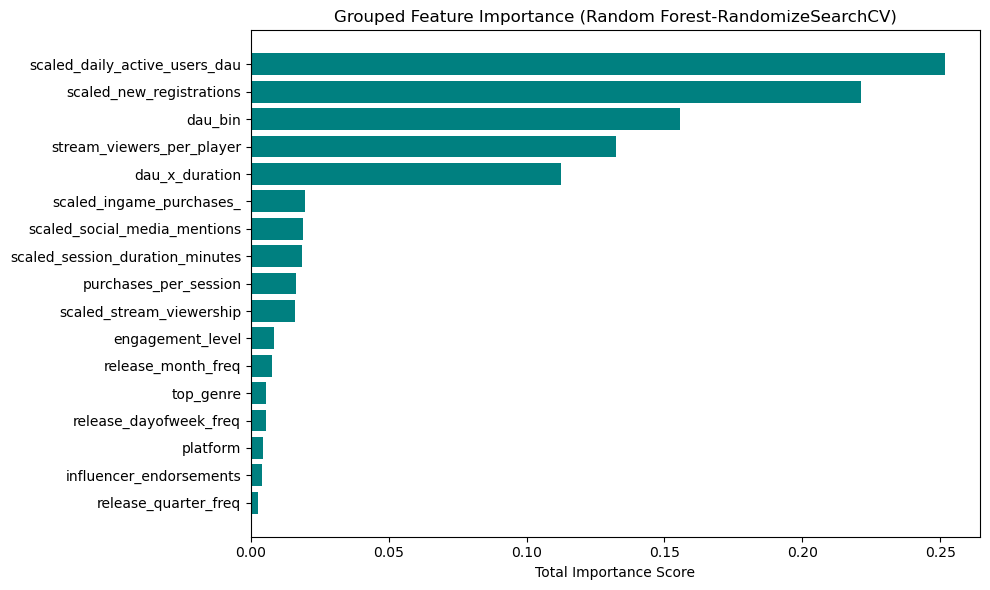

In [40]:
#-------Step 1:-------------------

#Extract and sort features
rf_best = random_search_rf.best_estimator_

#get feature importance and sort
importances = rf_best.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

#create a DataFrame for easy labeling
feat_imp_df = pd.DataFrame({
    'Feature':feature_names[indices],
    'Importance': importances[indices]
})

# Create an empty dictionary to hold grouped importances
grouped_importance = {}

# Iterate through feature names and assign groupings
for feature, importance in zip(feat_imp_df['Feature'], feat_imp_df['Importance']):
    if feature.startswith("top_genre_"):
        grouped_importance['top_genre'] = grouped_importance.get('top_genre', 0) + importance
    elif feature.startswith("platform_"):
        grouped_importance['platform'] = grouped_importance.get('platform', 0) + importance
    elif feature.startswith("engagement_level_"):
        grouped_importance['engagement_level'] = grouped_importance.get('engagement_level', 0) + importance
    elif feature.startswith("dau_bin_"):
        grouped_importance['dau_bin'] = grouped_importance.get('dau_bin', 0) + importance
    else:
        # Treat other features as is
        grouped_importance[feature] = grouped_importance.get(feature, 0) + importance

#convert to dataframe and sort
grouped_feat_imp_df = pd.DataFrame(list(grouped_importance.items()), columns = ['Feature Group', 'Total Importance'])
grouped_feat_imp_df = grouped_feat_imp_df.sort_values(by='Total Importance', ascending=False)

#-------Step 2:-------------------

#Plot Top N Features- 15 in this case
plt.figure(figsize=(10,6))
plt.barh(grouped_feat_imp_df['Feature Group'][::-1], grouped_feat_imp_df['Total Importance'][::-1], color='teal')
plt.xlabel('Total Importance Score')
plt.title('Grouped Feature Importance (Random Forest-RandomizeSearchCV)')
plt.tight_layout()
plt.show()

#### Top Insights by Stakeholder Group from Feature Importance Plot

* **Developers**

    * `scaled_daily_active_users_dau` emerged as the top overall feature. This highlights DAU as a core metric of game health.

    * Developers should focus on optimizing user retention and backend scalability for daily sessions.


* **Marketers**

    * `scaled_new_registrations` and `stream_viewers_per_player` are top marketing levers.

    * Suggests that stream visibility and sign-up funnels drive monetization.

    * `scaled_social_media_mentions` and `influencer_endorsements` have supporting impact, validating campaigns around visibility and reach.

* **Product Managers (PMs)**

    * `dau_bin`, `release_month_freq`, and `purchases_per_session` highlight temporal release strategies and retention buckets.

    * Indicates PMs should align release calendars and pricing strategies with known high-retention segments.

* **Designers**

    * `dau_x_duration` and `scaled_session_duration_minutes` show that session experience and in-game engagement loops affect monetization.

    * `engagement_level` supports designing sticky UX elements that keep users playing longer.

* **Publishers**

    * `scaled_ingame_purchases_`, `top_genre`, and `platform` are modest but consistent contributors.

    * Suggests publishers should monitor genre/platform monetization alignment to inform portfolio investment and distribution.

#### Residual Plot

**Residuals vs. Predicted Values**

* A residual plot was used to evaluate the accuracy and consistency of the model's predictions.
* Ideally, residuals should be randomly dispersed around zero, indicating a good fit.

* In this case, the distribution of residuals showed a reasonable spread, though with some variance due to the presence of outliers in the dataset.
* This visualisation confirmed that while the model captured genral trends well, there is still variablity in individual predictions, especially at extreme values.

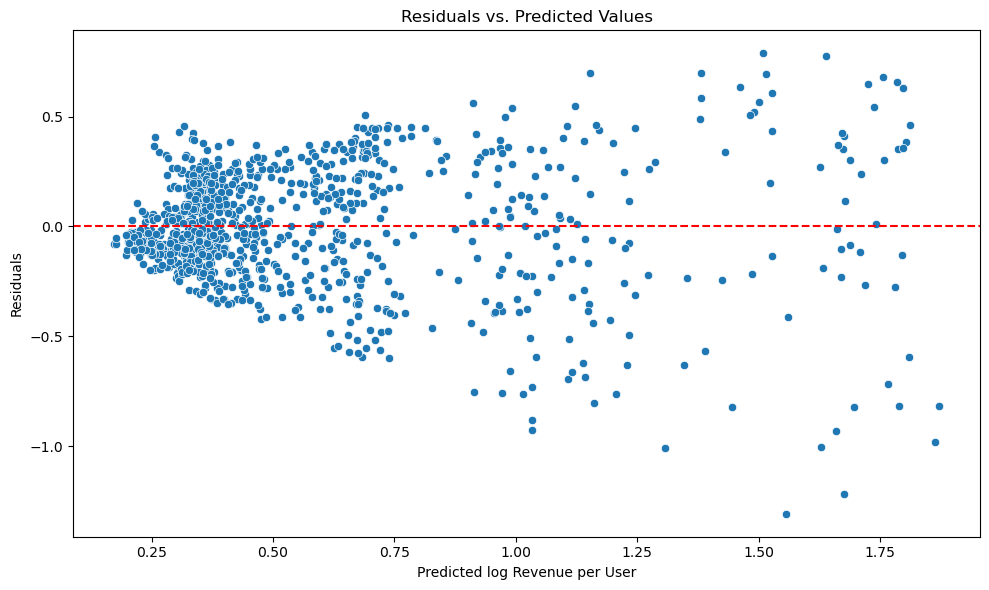

In [46]:
import seaborn as sns

y_pred = random_search_rf.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log Revenue per User')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.tight_layout()
plt.show()

#### Residual Plot Interpretation

* What’s Good:
    * Centered around 0: Most residuals are close to 0, which is expected for a reasonably good fit.

    * Reasonable spread for mid-range predictions.

* What’s Concerning:
    * Heteroscedasticity: The spread of residuals increases as predictions increase. That means:

    * Model performs better for low revenue users.

* Higher log revenue predictions (e.g, > 1.0) show more variance, both positive and negative.

* Slight curvature or funneling effect, possibly indicating non-linear patterns that the model isn’t fully capturing.

* Why the Residual Spread Increases:
  
    * The residual spread (variance) increases especially at the higher predicted values because:

      * Outliers are present, they are not removed due to the given the small dataset and business implications.

      * Those outliers, particularly high `revenue_per_user`, introduce extreme values that the model struggles to predict accurately, leading to:

        * High residual variance for high-value users.

        * Slight underfitting in the tails of the distribution.

* **Why Keeping Outliers Is Okay Here:**

    * In real-world business analytics, outliers often represent VIP customers or extreme cases that should not be discarded, **they hold strategic value.**

#### Distribution of Prediction Errors

A histogram of residuals was plotted to analyze the distribution of prediction errors from the final model.

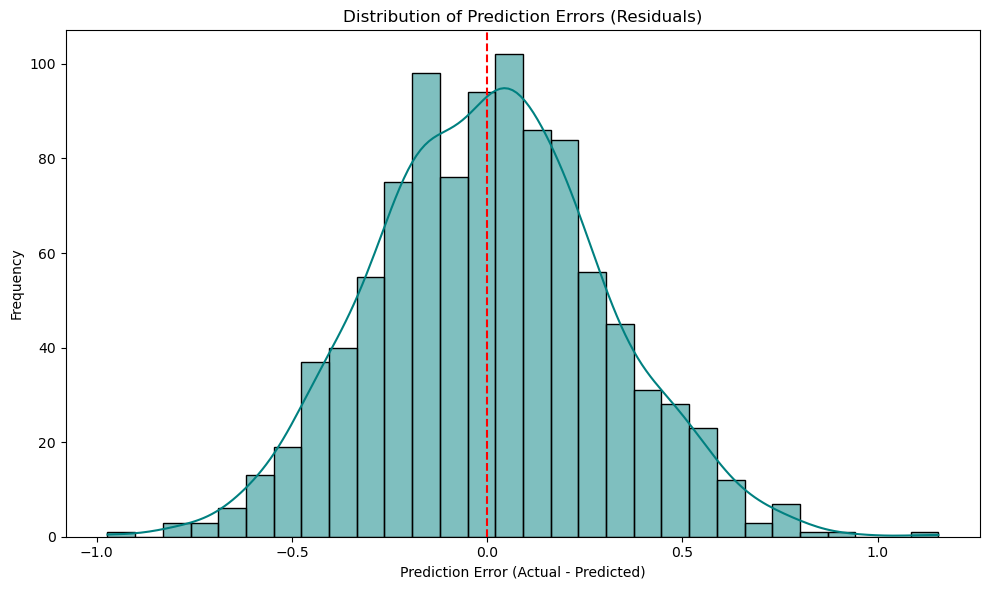

In [52]:
# Simulated residuals
np.random.seed(42)
residuals = np.random.normal(loc=0, scale=0.3, size=1000)

# Plotting error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Interpretation

* Centering around zero indicates no systemic over/under prediction.

* Symmetry suggests the model errors are unbiased.

* Long tails or skew might signal remaining outliers or non-linear effects.

## Deployment

#### Partial Dependence Plots (PDPs)

* Partial Dependence Plots were used to interpret how individual features influence the predicted revenue per user (RPU), while holding other features constant.
* These plots help visualize marginal effects and identify nonlinear relationships between features and the target variable.

* The stakeholder-aligned PDPs serve as the foundation for the capstone's insights recommender system.
* These plots allow each stakeholder grop - developers, marketers, designers and product managers to draw targeted, data-backed insights about monetization drivers.
* This framework can be further expanded into an interactive dashboard or integrated into real-time systems to deliver dynamic recommendations as new data becomes available.

In [291]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import MinMaxScaler

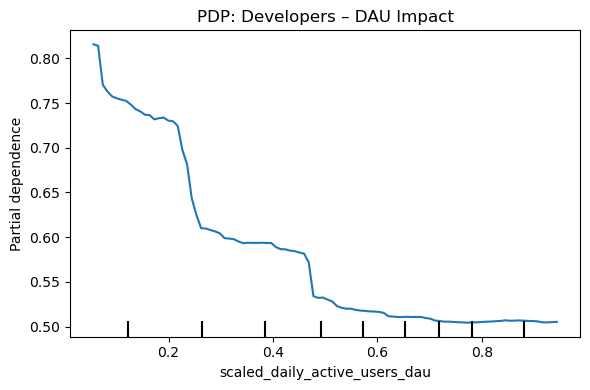

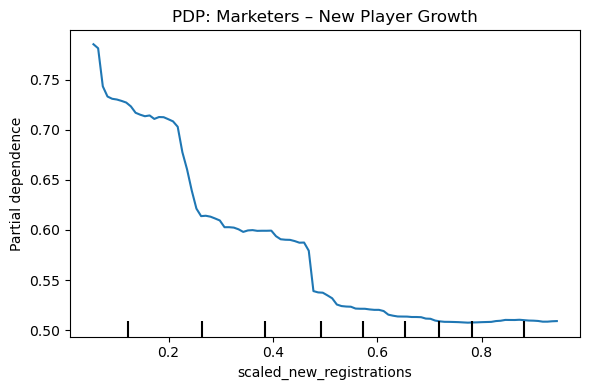

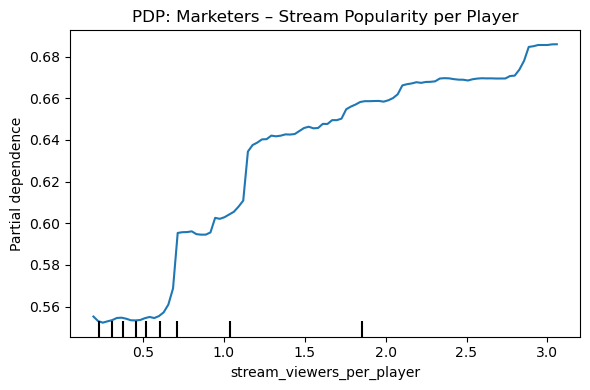

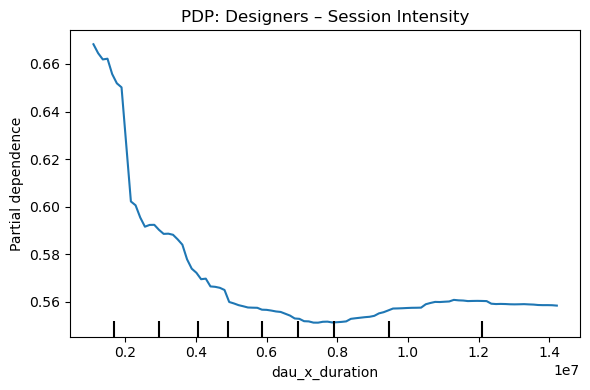

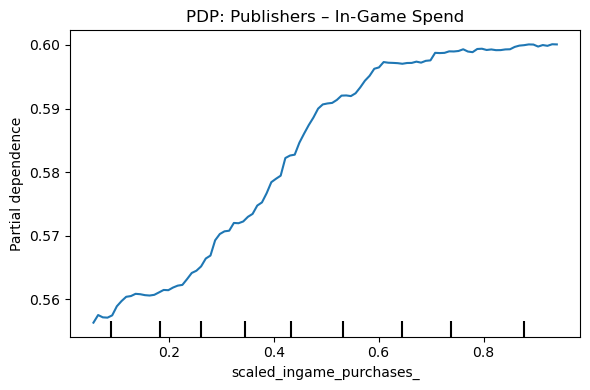

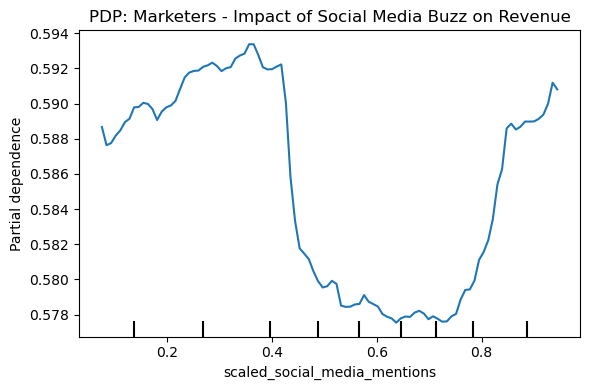

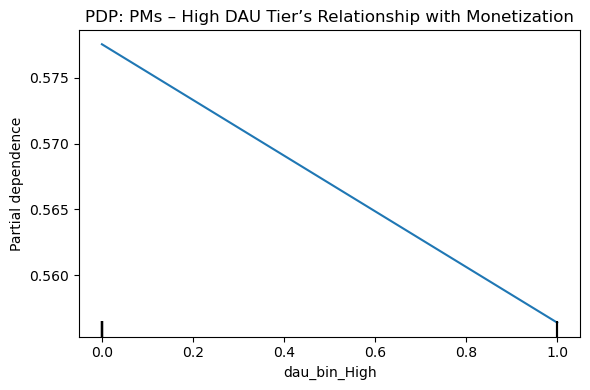

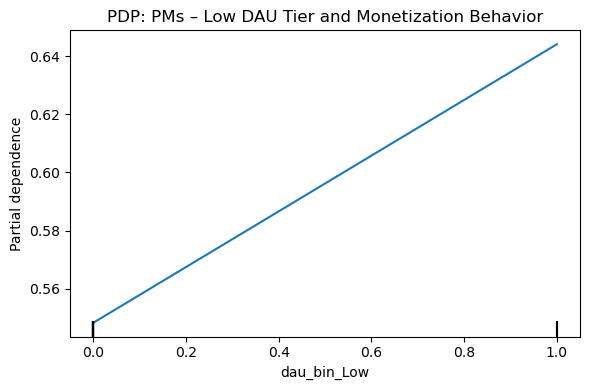

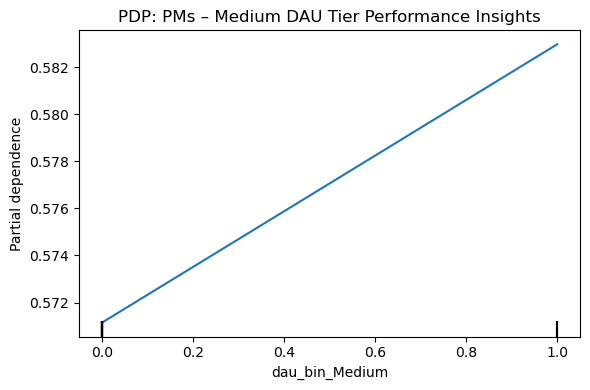

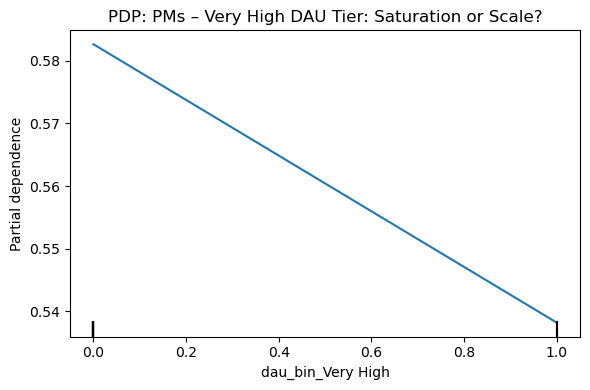

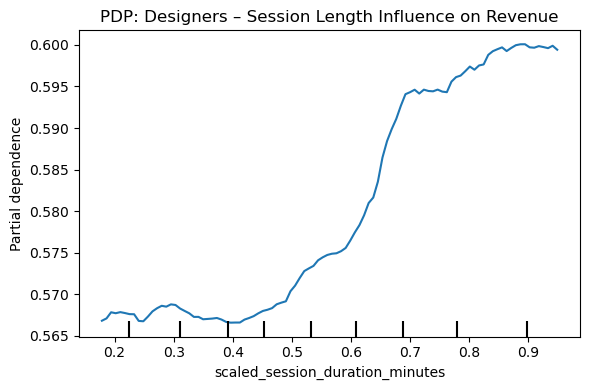

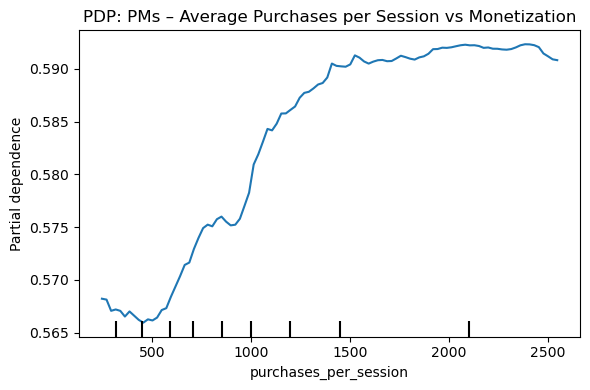

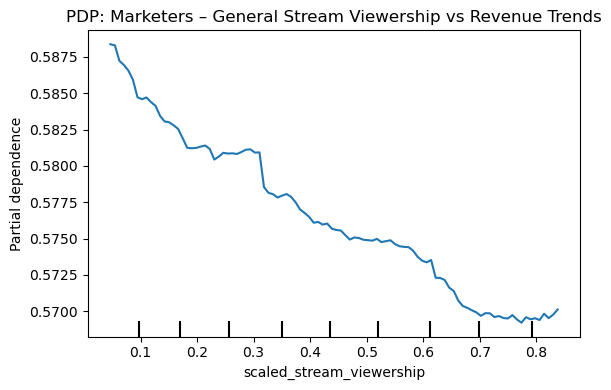

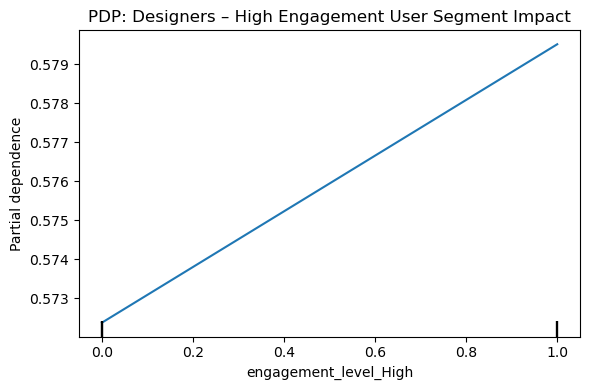

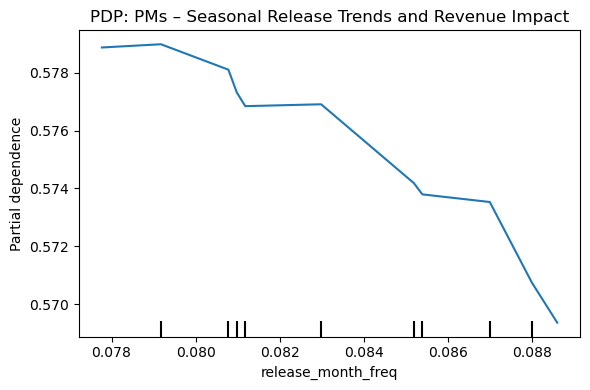

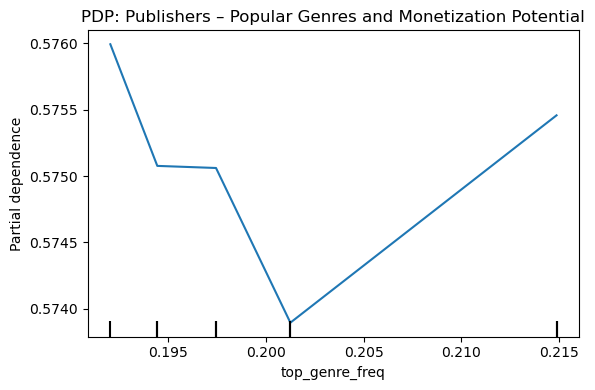

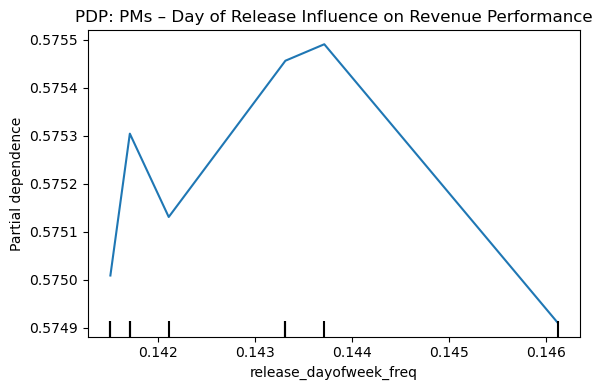

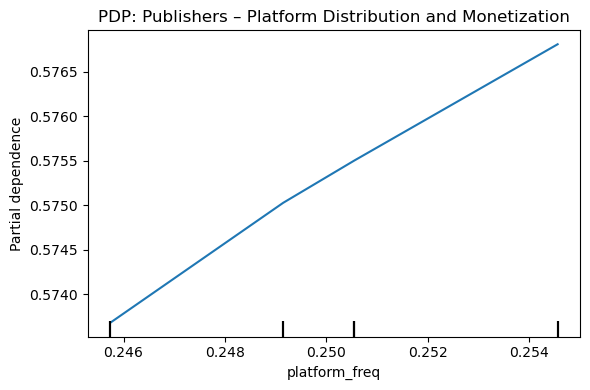

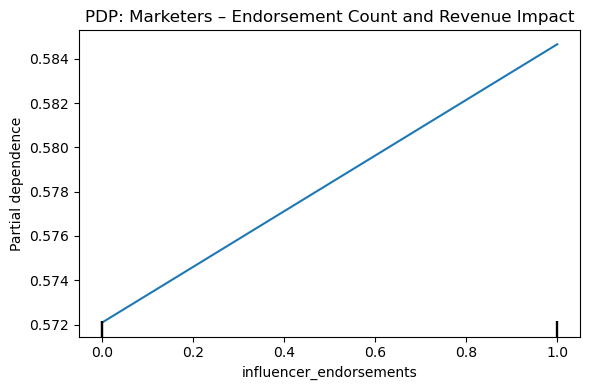

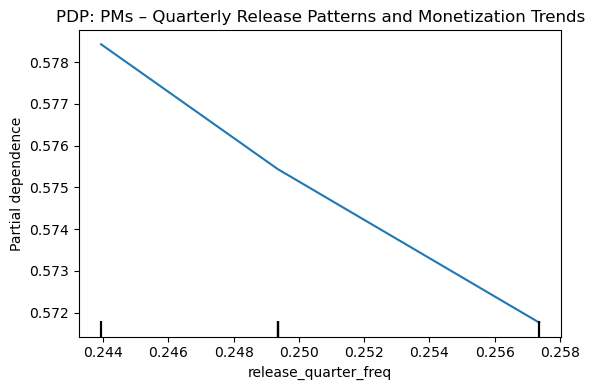

In [319]:
# Top features from feature importance
top_features = [
    'scaled_daily_active_users_dau',
    'scaled_new_registrations',
    'stream_viewers_per_player',
    'dau_x_duration',
    'scaled_ingame_purchases_',
    'scaled_social_media_mentions',
    'dau_bin_High',
    'dau_bin_Low',
    'dau_bin_Medium',
    'dau_bin_Very High',
    'scaled_session_duration_minutes',
    'purchases_per_session',
    'scaled_stream_viewership',
    'engagement_level_High',
    'release_month_freq',
    'top_genre_freq',
    'release_dayofweek_freq',
    'platform_freq',
    'influencer_endorsements',
    'release_quarter_freq'
]

titles = {
    'scaled_daily_active_users_dau': 'Developers – DAU Impact',
    'scaled_new_registrations': 'Marketers – New Player Growth',
    'dau_x_duration': 'Designers – Session Intensity',
    'scaled_ingame_purchases_': 'Publishers – In-Game Spend',
    'stream_viewers_per_player': 'Marketers – Stream Popularity per Player',
    'scaled_social_media_mentions': 'Marketers - Impact of Social Media Buzz on Revenue',
    'dau_bin_High': 'PMs – High DAU Tier’s Relationship with Monetization',
    'dau_bin_Low': 'PMs – Low DAU Tier and Monetization Behavior',
    'dau_bin_Medium': 'PMs – Medium DAU Tier Performance Insights',
    'dau_bin_Very High':'PMs – Very High DAU Tier: Saturation or Scale?',
    'scaled_session_duration_minutes':'Designers – Session Length Influence on Revenue',
    'purchases_per_session':'PMs – Average Purchases per Session vs Monetization',
    'scaled_stream_viewership':'Marketers – General Stream Viewership vs Revenue Trends',
    'engagement_level_High':'Designers – High Engagement User Segment Impact',
    'release_month_freq':'PMs – Seasonal Release Trends and Revenue Impact',
    'top_genre_freq':'Publishers – Popular Genres and Monetization Potential',
    'release_dayofweek_freq':'PMs – Day of Release Influence on Revenue Performance',
    'platform_freq':'Publishers – Platform Distribution and Monetization',
    'influencer_endorsements':'Marketers – Endorsement Count and Revenue Impact',
    'release_quarter_freq':'PMs – Quarterly Release Patterns and Monetization Trends'
    
}

# PDP plot
for feature in top_features:
    fig, ax = plt.subplots(figsize=(6, 4))

    # Display PDP and save the display object to access plot lines
    disp = PartialDependenceDisplay.from_estimator(
        random_search_rf, X_test, [feature], ax=ax
    )

    # Set plot title using stakeholder-friendly titles
    ax.set_title(f"PDP: {titles.get(feature, feature)}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)

    plt.tight_layout()
    plt.show()